# Post-processing of case studies

## Usage notes

All figures will be written to the directory `img` as pdf and png files.

It will look for results in a "simulation/<simulator>" folder on the same level as this notebook. Simulators currently supported: "dymola", "optimica"

## Import required libraries

In [1]:
import os
import cases

import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from buildingspy.io.outputfile import Reader
from buildingspy.io.postprocess import Plotter

## Load in simulation results

In [2]:
# Helper methods

def get_results(case_name, simulator = "dymola"):
    """ Get the results for the case with name `case_name`
    from a "simulation/<simulator>" folder.

    Parameters:
    
        simulator: str
            "optimica" or "dymola"

    Returns:

        Reader: buildingspy.io.outputpy.Reader instance
    """
    if simulator not in ["dymola", "optimica"]:
        raise Exception("Unsupported simulator provided.")

    # First make sure that the simulation was successful

    # For results generated using Dymola
    if simulator == "dymola":

        dslog_name = os.path.join("simulations", simulator, case_name, "dslog.txt")
        with open(dslog_name) as dslog:
            if not "Integration terminated successfully" in dslog.read():
                raise Exception("Simulation failed. Check {}".format(dslog_name))

    # For results generated using Optimica
    elif simulator == "optimica":

        for file in os.listdir(os.path.join("simulations", simulator, case_name)):
            if '.json' in file:
                json_log_fullpath = os.path.join("simulations", simulator, case_name, file)
                import json
                if not json.load(open(json_log_fullpath))["translation"]["success"]:
                    raise Exception("Simulation failed. Check {}".format(json_log_fullpath))
    
    else:
        raise Exception("Simulation log found for neither supported simulation engine.")

    file_name = cases.get_result_fullpath(case_name, simulator)

    return Reader(file_name, simulator)


def get_partial_results(case_name, list_of_variables, simulator = "dymola", 
                        as_dataframe = False, equidistant = False):
    """ Get a dictionary with the variable names and the time series for `list_of_variables`

    Parameters:
    
        case_name: str
            Name of the simulated case

        list_of_variables: list
            Variable names for which to extract the result data

        simulator: str
            "optimica" or "dymola" 

        as_dataframe: bool
            If all variables have the same time record in the output one may convert the 
            resulting dictionary into a dataframe
            
        equidistant: bool
            Adds a column with the timestep size, if the results are with
            an equidistant timestep (no events).

    Returns:

        d: dataframe or dict
            holds time and varable for each variable listed in list_of_variables
    """
    reader = get_results(case_name, simulator = simulator)
    d = dict()
    for v in list_of_variables:
        try:
            d['time_' + v] = reader.values(v)[0]
            d[v] = reader.values(v)[1]
        except:
            print("Variable {} not found in case {} for simulator {}".format(v, case_name, simulator))

    if as_dataframe:
        import pandas as pd
        d = pd.DataFrame(d)
        if equidistant:
            d['ts_duration_min'] = pd.Series(
                d['time_' + list_of_variables[0]][1:].values - d[
                    'time_' + list_of_variables[0]][:-1].values).unique()[0]/60

    return d

In [3]:
# Read in all simulation results

all_case_names = cases.get_list_of_case_names()
print("Found cases:", all_case_names)

# res = {"optimica" : dict(), "dymola" : dict()}
# simulators = ["dymola", "optimica"]

res = {"dymola" : dict()}
simulators = ["dymola"]

for simulator in simulators:
    for case_name in all_case_names:
        try:
            res[simulator][case_name] = get_results(case_name, simulator)
        except:
            print("Warning: Could not read results, please check simulation log file: ", case_name)

print("Read in simulation results.")

Found cases: ['base_summer', 'alt_summer', 'base_annual', 'alt_annual']
Read in simulation results.


## Explore variables found in the simulation results

In [4]:
# aggregate data timeseries

PAgg = {"dymola": dict()}#, "optimica": dict()}
simulators = ["dymola"]#, "optimica"]
for simulator in simulators:
    for case in all_case_names:
        PAgg[simulator][case] = get_partial_results(
            case,  ["PConWatPumAgg.y", "PWSEWatPumAgg.y", "PCooTowWatPumAgg.y", "PChiWatPumAgg.y", "PChiAgg.y", "PCooTowAgg.y", "PSupFanAgg.y","QRooIntGaiAgg.y"], 
            simulator, as_dataframe=True, equidistant = simulator == "dymola")
        PAgg[simulator][case] = PAgg[simulator][case].loc[(PAgg[simulator][case].index % 2)==0,:].reset_index(drop=True)

Variable PWSEWatPumAgg.y not found in case alt_summer for simulator dymola
Variable PCooTowWatPumAgg.y not found in case alt_summer for simulator dymola
Variable PWSEWatPumAgg.y not found in case alt_annual for simulator dymola
Variable PCooTowWatPumAgg.y not found in case alt_annual for simulator dymola


In [5]:
PAgg["dymola"]['base_annual'].tail()/(1000*3600)

,time_PConWatPumAgg.y,PConWatPumAgg.y,time_PWSEWatPumAgg.y,PWSEWatPumAgg.y,time_PCooTowWatPumAgg.y,PCooTowWatPumAgg.y,time_PChiWatPumAgg.y,PChiWatPumAgg.y,time_PChiAgg.y,PChiAgg.y,time_PCooTowAgg.y,PCooTowAgg.y,time_PSupFanAgg.y,PSupFanAgg.y,time_QRooIntGaiAgg.y,QRooIntGaiAgg.y,ts_duration_min
52556,8.759333,13.12994,8.759333,15264.136533,8.759333,1401.151147,8.759333,2948.334933,8.759333,5.48189,8.759333,56933.498880,8.759333,99013.518222,8.759333,4.377167e+06,0.000001
52557,8.759500,13.12994,8.759500,15264.427804,8.759500,1401.177742,8.759500,2948.363947,8.759500,5.48189,8.759500,56934.582044,8.759500,99015.402382,8.759500,4.377250e+06,0.000001
52558,8.759667,13.12994,8.759667,15264.717938,8.759667,1401.204196,8.759667,2948.392676,8.759667,5.48189,8.759667,56935.665209,8.759667,99017.286542,8.759667,4.377333e+06,0.000001
52559,8.759833,13.12994,8.759833,15265.008071,8.759833,1401.230791,8.759833,2948.421404,8.759833,5.48189,8.759833,56936.748373,8.759833,99019.170702,8.759833,4.377417e+06,0.000001
52560,8.760000,13.12994,8.760000,15265.299342,8.760000,1401.257244,8.760000,2948.450133,8.760000,5.48189,8.760000,56937.831538,8.760000,99021.054862,8.760000,4.377500e+06,0.000001


In [6]:
500000 * 8760/(1000)/1000/290

15.10344827586207

In [7]:
PAgg["dymola"]['alt_annual'].head(20)

,time_PConWatPumAgg.y,PConWatPumAgg.y,time_PChiWatPumAgg.y,PChiWatPumAgg.y,time_PChiAgg.y,PChiAgg.y,time_PCooTowAgg.y,PCooTowAgg.y,time_PSupFanAgg.y,PSupFanAgg.y,time_QRooIntGaiAgg.y,QRooIntGaiAgg.y,ts_duration_min
0,0.0,0.000000e+00,0.0,0.00,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,5.0
1,600.0,0.000000e+00,600.0,0.00,600.0,0.00000,600.0,0.000000,600.0,6782264.0,600.0,2500000.0,5.0
2,1200.0,0.000000e+00,1200.0,0.00,1200.0,0.00000,1200.0,0.000000,1200.0,13564528.0,1200.0,10000000.0,5.0
3,1800.0,0.000000e+00,1800.0,0.00,1800.0,0.00000,1800.0,0.000000,1800.0,20346792.0,1800.0,22500000.0,5.0
4,2400.0,4.529710e+03,2400.0,2025882.00,2400.0,198388.34375,2400.0,0.000000,2400.0,27129056.0,2400.0,40000000.0,5.0
5,3000.0,1.173785e+06,3000.0,2260837.00,3000.0,198388.34375,3000.0,31534.576172,3000.0,33911320.0,3000.0,62500000.0,5.0
6,3600.0,2.343041e+06,3600.0,2364535.25,3600.0,198388.34375,3600.0,31534.576172,3600.0,40693584.0,3600.0,90000000.0,5.0
7,4200.0,3.512297e+06,4200.0,2468233.75,4200.0,198388.34375,4200.0,31534.576172,4200.0,47475848.0,4200.0,122500000.0,5.0
8,4800.0,4.681552e+06,4800.0,2571932.00,4800.0,198388.34375,4800.0,31534.576172,4800.0,54258112.0,4800.0,160000000.0,5.0
9,5400.0,5.850808e+06,5400.0,2675630.50,5400.0,198388.34375,5400.0,31534.576172,5400.0,61040376.0,5400.0,202500000.0,5.0


In [8]:
data = {"dymola": dict()}#, "optimica": dict()}
simulators = ["dymola"]#, "optimica"]

for simulator in simulators:
    
    for case in all_case_names:
        
        var_labels = ["weaBus.TWetBul", "pumCW.m_flow", "chilledWaterReset.uChiWatPlaRes","chilledWaterReset.TChiWatSupSet",
                      "chilledWaterReset.dpChiWatPumSet", "pumCW.VMachine_flow", "pumCW.eta", "pumCW.P", "TAirSup.T", "chi.on", 
                      "cooTow.y", "pumCW.m_flow", "chi.m1_flow"]
            
        var_labels += ["chi.PLR2", "chi.PLR1", "chi.P", "chi.TEvaLvg", "chi.TEvaEnt", "chi.TConLvg", "chi.TConEnt"]
        
        if 'base' in case:
            var_labels += ["pumCWWSE.m_flow", "pumCT.m_flow", "waterSideEconomizerOnOff.yOn"]
            
        elif 'alt' in case:
            var_labels += ["heaPreCon.yHeaPreConVal", "yWSEOn.y"]
            
        data[simulator][case] = get_partial_results(
            case,  var_labels, simulator, as_dataframe = True)
        
        data[simulator][case] = data[simulator][case].loc[(data[simulator][case].index % 2)==0,:].reset_index(drop = True)
        data[simulator][case] = data[simulator][case][data[simulator][case].columns.drop(list(data[simulator][case].filter(regex='time_')))]


In [9]:
print(data["dymola"]["alt_annual"].describe().round(2))

       weaBus.TWetBul  pumCW.m_flow  chilledWaterReset.uChiWatPlaRes  \
count        52561.00      52561.00                         52561.00   
mean           284.30         19.90                             0.11   
std              4.60          1.08                             0.02   
min            271.43          0.00                             0.00   
25%            280.84         19.84                             0.10   
50%            284.48         19.84                             0.10   
75%            287.54         19.84                             0.10   
max            296.59         39.68                             0.87   

       chilledWaterReset.TChiWatSupSet  chilledWaterReset.dpChiWatPumSet  \
count                         52561.00                          52561.00   
mean                            295.15                          37889.33   
std                               0.05                           4018.12   
min                             283.04         

In [10]:
print(data["dymola"]["base_annual"].describe().round(2))

       weaBus.TWetBul  pumCW.m_flow  chilledWaterReset.uChiWatPlaRes  \
count        52561.00      52561.00                         52561.00   
mean           284.30          0.02                             0.03   
std              4.60          0.57                             0.04   
min            271.43          0.00                             0.00   
25%            280.84          0.00                             0.00   
50%            284.48          0.00                             0.01   
75%            287.54          0.00                             0.04   
max            296.59         19.84                             1.00   

       chilledWaterReset.TChiWatSupSet  chilledWaterReset.dpChiWatPumSet  \
count                         52561.00                          52561.00   
mean                            295.14                          19300.11   
std                               0.37                           9217.30   
min                             278.71         

### Sizing considerations

In [11]:
# aggregate data timeseries

data_df = {"dymola": dict()}
simulators = ["dymola"]
for simulator in simulators:
    for case in all_case_names:
        data_df[simulator][case] = get_partial_results(
            case,  ["chi.COP", "chi.TSet", "chilledWaterReset.TChiWatSupSet", "chilledWaterReset.uChiWatPlaRes", "chi.TEvaLvg", "chi.TEvaEnt", "chi.TConLvg", "chi.TConEnt", "weaBus.TWetBul", "cooTow.y", "TCHWEntChi.T"], 
            simulator, as_dataframe=True, equidistant = simulator == "dymola")
        
        data_df[simulator][case] = data_df[simulator][case].loc[(data_df[simulator][case].index % 2)==0,:].reset_index(drop=True)
        data_df["dymola"][case] = data_df["dymola"][case][data_df["dymola"][case].columns.drop(list(data_df["dymola"][case].filter(regex='time_')))]

In [12]:
print(data_df["dymola"]["base_annual"].describe().round(2))
# data_df["dymola"]["base_annual"].loc[(data_df["dymola"]["base_annual"]["chilledWaterReset.TChiWatSupSet"] > 288) & (data_df["dymola"]["base_annual"]["chilledWaterReset.TChiWatSupSet"] < 291),:]
print((data_df["dymola"]["base_annual"]["chilledWaterReset.uChiWatPlaRes"] > 0.8).sum())
print((data_df["dymola"]["base_annual"]["chilledWaterReset.uChiWatPlaRes"] <= 0.8).sum())
data_df["dymola"]["base_annual"].shape

        chi.COP  chi.TSet  chilledWaterReset.TChiWatSupSet  \
count  52561.00  52561.00                         52561.00   
mean       0.01    295.14                           295.14   
std        0.35      0.37                             0.37   
min        0.00    278.71                           278.71   
25%        0.00    295.15                           295.15   
50%        0.00    295.15                           295.15   
75%        0.00    295.15                           295.15   
max       14.08    295.15                           295.15   

       chilledWaterReset.uChiWatPlaRes  chi.TEvaLvg  chi.TEvaEnt  chi.TConLvg  \
count                         52561.00     52561.00     52561.00     52561.00   
mean                              0.03       292.44       290.93       296.15   
std                               0.04         1.52         2.67         2.04   
min                               0.00       290.47       279.87       293.05   
25%                               0.

(52561, 12)

In [13]:
296.18 - 273.15

23.03000000000003

In [14]:
print("Chiller on fraction, alternative: ", 
      data["dymola"]["alt_annual"].groupby(["chi.on"]).count().reset_index().iloc[1,1]/data["dymola"]["alt_annual"].groupby(["chi.on"]).count().reset_index().iloc[0,1])
print("Chiller on fraction, base: ", 
      data["dymola"]["base_annual"].groupby(["chi.on"]).count().reset_index().iloc[1,1]/data["dymola"]["alt_annual"].groupby(["chi.on"]).count().reset_index().iloc[0,1])

Chiller on fraction, alternative:  0.0029002652216222405
Chiller on fraction, base:  0.0008395504588906486


In [15]:
data["dymola"]["alt_annual"].loc[data["dymola"]["alt_annual"]["chi.on"] == 1.,["cooTow.y","weaBus.TWetBul"]]

,cooTow.y,weaBus.TWetBul
26719,1.000000,295.148163
26720,0.978501,295.240845
26721,1.000000,295.337250
26722,1.000000,295.432373
26723,1.000000,295.521820
...,...,...
33848,0.290223,287.420685
33849,0.290103,287.387634
33850,0.289986,287.355377
33851,0.289858,287.319153


In [16]:
data["dymola"]["base_annual"].loc[data["dymola"]["base_annual"]["chi.on"] == 1.,["cooTow.y","weaBus.TWetBul"]]

,cooTow.y,weaBus.TWetBul
26726,1.0,295.762451
26727,1.0,295.843781
26728,1.0,295.916443
26729,1.0,295.973358
26730,1.0,296.007324
26731,1.0,296.022217
26732,1.0,296.028992
26733,1.0,296.031036
26734,1.0,296.031769
26735,1.0,296.034607


In [17]:
# print(data["dymola"]["alt_all_annual"].describe().round(2))

chi_on_alt = data["dymola"]["alt_annual"][data["dymola"]["alt_annual"]["chi.on"]>0]

chi_on_base = data["dymola"]["base_annual"][data["dymola"]["base_annual"]["chi.on"]>0]

print(chi_on_base.describe().round(2))

       weaBus.TWetBul  pumCW.m_flow  chilledWaterReset.uChiWatPlaRes  \
count           44.00         44.00                            44.00   
mean           294.61         19.84                             0.71   
std              1.83          0.00                             0.37   
min            290.99         19.84                             0.17   
25%            293.09         19.84                             0.30   
50%            295.68         19.84                             1.00   
75%            296.03         19.84                             1.00   
max            296.59         19.84                             1.00   

       chilledWaterReset.TChiWatSupSet  chilledWaterReset.dpChiWatPumSet  \
count                            44.00                             44.00   
mean                            285.14                         107655.95   
std                               7.87                          32273.15   
min                             278.71         

In [18]:
# fig = plt.figure(figsize=(4.5, 4.5))
# ax = fig.add_subplot(1, 1, 1)

# ax.scatter(chi_on_alt["cooTow.y"], chi_on_alt["weaBus.TWetBul"], linewidth=0.5, s = 1.)

# save_plot(fig, "test")

In [19]:
int(len(chi_on_base)*0.1)

4

In [20]:
print(chi_on_alt.describe().round(2))

       weaBus.TWetBul  pumCW.m_flow  chilledWaterReset.uChiWatPlaRes  \
count          152.00        152.00                           152.00   
mean           291.68         39.68                             0.17   
std              3.18          0.00                             0.00   
min            287.27         39.68                             0.17   
25%            288.60         39.68                             0.17   
50%            291.35         39.68                             0.17   
75%            295.02         39.68                             0.17   
max            296.59         39.68                             0.19   

       chilledWaterReset.TChiWatSupSet  chilledWaterReset.dpChiWatPumSet  \
count                           152.00                            152.00   
mean                            295.15                          53385.35   
std                               0.00                            300.72   
min                             295.15         

### Some statistics

In [21]:
# to add months to equidistant data

df = data["dymola"]['base_annual']
df['12 bins'] = list(df.index/(5401/12))
df['12 bins'] = np.ceil(df['12 bins'])

count_wse_on_per_month = df.groupby('12 bins').sum()["waterSideEconomizerOnOff.yOn"].reset_index()

# df.index

# list(df.index/12)

# base_annual = df[df["chi.on"] != 1.][df["waterSideEconomizerOnOff.yOn"] == 1.]
df1 = data["dymola"]['alt_annual']
# wse_annual = df1[df1["chi.on"] != 1.][df1["yWSEOn.y"] == 1.]
# df2 = data["dymola"]['alt_heapreval_wse_annual']
# cwreset_wse_annual = df2[df2["chi.on"] != 1.][df2["yWSEOn.y"] == 1.]

# print(base_annual.shape)
# print(wse_annual.shape)
# print(cwreset_wse_annual.shape)



In [22]:
pd.options.display.float_format = '{:,.2f}'.format

data1 = data.copy()

for case in all_case_names:
    data1["dymola"][case] = data["dymola"][case][data["dymola"][case].columns.drop(list(data["dymola"][case].filter(regex='time_')))]

for case in all_case_names:
    print("\n {case_name}, simulation averages: \n".format(case_name = case))

    print(data1["dymola"][case].mean())
    print("\nChiller ON % of time", data1["dymola"][case].mean()["chi.on"])
    try:
        print("WSE ON % of time", data1["dymola"][case].mean()["waterSideEconomizerOnOff.yOn"])
        print("Data records where WSE is on and chiller is not:", data1["dymola"][case].loc[
            :, "waterSideEconomizerOnOff.yOn"].sum() - sum(data1["dymola"][case].loc[
            :, "waterSideEconomizerOnOff.yOn"] == data1["dymola"][case].loc[:, "chi.on"]))
    except:
        print("WSE ON % of time", data1["dymola"][case].mean()["yWSEOn.y"])
        print("Data records where WSE is on and chiller is not:", data1["dymola"][case].loc[
            :, "yWSEOn.y"].sum() - sum(data1["dymola"][case].loc[
            :, "yWSEOn.y"] == data1["dymola"][case].loc[:, "chi.on"]))


 base_summer, simulation averages: 

weaBus.TWetBul                        288.76
pumCW.m_flow                            0.07
chilledWaterReset.uChiWatPlaRes         0.07
chilledWaterReset.TChiWatSupSet       295.15
chilledWaterReset.dpChiWatPumSet   27,983.88
pumCW.VMachine_flow                     0.00
pumCW.eta                               0.49
pumCW.P                                 6.03
TAirSup.T                             300.20
chi.on                                  0.00
cooTow.y                                1.00
chi.m1_flow                             0.07
chi.PLR2                                0.00
chi.PLR1                                0.00
chi.P                                   1.95
chi.TEvaLvg                           294.30
chi.TEvaEnt                           293.48
chi.TConLvg                           294.01
chi.TConEnt                           296.24
pumCWWSE.m_flow                        19.84
pumCT.m_flow                           19.91
waterSideEconomiz

In [23]:
# data1["dymola"]["alt_all_annual"][data1["dymola"]["alt_all_annual"]["cooTow.y"]<=0.2]
# data1["dymola"]["base_annual"][data1["dymola"]["base_annual"]["cooTow.y"]==0.]

# Compile total energy use per device, case, and simulator

## Energy use

We obtain the energy use as cumulative power consumed by:

- Zone supply fan: fan.P
- Chilled water pump: pumCHW.P
- Condenser water pump: pumCW.P
- Chiller: chi.P
- Cooling tower: cooTow.PFan

We also look at the aggregate IT Heat Load

In [24]:
vlmap = {
    "PConWatPumAgg.y" : "CW Pump",
    "PWSEWatPumAgg.y" : "WSE Pump",
    "PCooTowWatPumAgg.y" : "CT Pump",  
    "PChiWatPumAgg.y" : "CHW Pump",
    "PChiAgg.y" : "Chiller",
    "PCooTowAgg.y" : "Cooling Tower Fan",
    "PSupFanAgg.y" : "Supply Fan",
    "QRooIntGaiAgg.y" : "Data Center Zone Load"
}


# Season: use value from the case dist

# Controller design: use long name of the case dict

# *mg add season later

# PAgg_compiled = pd.DataFrame(columns = [["Simulator", "Controller Design", "Season"] + list(vlmap.values())])
PAgg_compiled = pd.DataFrame()

inx = 0

for simulator in simulators:
    for case in cases.get_cases():
        PAgg_compiled.loc[inx, "Simulator"] = simulator
        PAgg_compiled.loc[inx, "Controller Design"] = case['long_name'][:-8]
        PAgg_compiled.loc[inx, "Season"] = case['season']
        for var in list(vlmap.keys()):
            # grab the last value in the cumulative result variables and convert to kWh from Ws
            try:
                PAgg_compiled.loc[inx, vlmap[var]] = (PAgg[simulator][case['name']].loc[:,var][-1:].values[0]/(1000*3600)).round(1)
            except:
                PAgg_compiled.loc[inx, vlmap[var]] = np.nan

        inx += 1

# e.g. lights, people, UPSs
fraction_IT_load = .8
PAgg_compiled["Non-IT Heat Load"] = PAgg_compiled["Data Center Zone Load"] * (1 - fraction_IT_load)
PAgg_compiled["IT Heat Load"] = PAgg_compiled["Data Center Zone Load"] * fraction_IT_load

PAgg_compiled = PAgg_compiled.drop(columns = ["Data Center Zone Load"])
PAgg_compiled["Total Energy Use [kWh]"] = PAgg_compiled.loc[:,vlmap['PConWatPumAgg.y'] : vlmap["PSupFanAgg.y"]].sum(axis = 1)
PAgg_compiled["Total Energy Use incl. non-IT [kWh]"] = PAgg_compiled.loc[:,vlmap['PConWatPumAgg.y'] : "Non-IT Heat Load"].sum(axis = 1)

PAgg_compiled

,Simulator,Controller Design,Season,CW Pump,WSE Pump,CT Pump,CHW Pump,Chiller,Cooling Tower Fan,Supply Fan,Non-IT Heat Load,IT Heat Load,Total Energy Use [kWh],Total Energy Use incl. non-IT [kWh]
0,dymola,Base-case,summer,13.90,"3,973.00",370.50,"1,328.10",5.90,"14,819.90","25,772.60","228,000.00","912,000.00","46,283.90","274,283.90"
1,dymola,Alternative,summer,"4,583.60",nan,nan,"2,151.00",423.90,"4,834.40","25,772.60","228,000.00","912,000.00","37,765.50","265,765.50"
2,dymola,Base-case,annual,13.10,"15,265.30","1,401.30","2,948.50",5.50,"56,937.80","99,021.10","875,500.02","3,502,000.08","175,592.60","1,051,092.62"
3,dymola,Alternative,annual,"17,210.70",nan,nan,"7,582.30",422.60,"6,878.30","99,021.10","875,500.08","3,502,000.32","131,115.00","1,006,615.08"


In [25]:
PAgg_compiled

,Simulator,Controller Design,Season,CW Pump,WSE Pump,CT Pump,CHW Pump,Chiller,Cooling Tower Fan,Supply Fan,Non-IT Heat Load,IT Heat Load,Total Energy Use [kWh],Total Energy Use incl. non-IT [kWh]
0,dymola,Base-case,summer,13.90,"3,973.00",370.50,"1,328.10",5.90,"14,819.90","25,772.60","228,000.00","912,000.00","46,283.90","274,283.90"
1,dymola,Alternative,summer,"4,583.60",nan,nan,"2,151.00",423.90,"4,834.40","25,772.60","228,000.00","912,000.00","37,765.50","265,765.50"
2,dymola,Base-case,annual,13.10,"15,265.30","1,401.30","2,948.50",5.50,"56,937.80","99,021.10","875,500.02","3,502,000.08","175,592.60","1,051,092.62"
3,dymola,Alternative,annual,"17,210.70",nan,nan,"7,582.30",422.60,"6,878.30","99,021.10","875,500.08","3,502,000.32","131,115.00","1,006,615.08"


In [26]:
# annual savings
print("Annual savings in alternative case: ", 
      (PAgg_compiled.loc[2,"Total Energy Use [kWh]"]-PAgg_compiled.loc[3,"Total Energy Use [kWh]"])/PAgg_compiled.loc[2,"Total Energy Use [kWh]"])
print("Seasonal savings in alternative case: ",
      (PAgg_compiled.loc[0,"Total Energy Use [kWh]"]-PAgg_compiled.loc[1,"Total Energy Use [kWh]"])/PAgg_compiled.loc[0,"Total Energy Use [kWh]"])

Annual savings in alternative case:  0.2532999682218955
Seasonal savings in alternative case:  0.18404672034984076


## Energy performance metrics: PUE

## For the plant

In [27]:
pue_df = PAgg_compiled.loc[:, ["Total Energy Use incl. non-IT [kWh]", "IT Heat Load"]].copy()
pue_only =pd.DataFrame()

pue_df["PUE"] = pue_df.sum(axis = 1.).divide(pue_df["IT Heat Load"])

pue_only["PUE"] = pue_df.sum(axis = 1.).divide(pue_df["IT Heat Load"])

pue_df["Simulator"] = PAgg_compiled["Simulator"].copy()
pue_df["Controller Design"] = PAgg_compiled["Controller Design"].copy()

pue_only["Simulator"] = PAgg_compiled["Simulator"].copy()
pue_only["Controller Design"] = PAgg_compiled["Controller Design"]
# pue_df
# pue_only = 
# pue_df.loc[:, "PUE", "Simulator", "Controller Design"]
pue_only["Season"] = PAgg_compiled["Season"].copy()
pue_only

,PUE,Simulator,Controller Design,Season
0,1.30,dymola,Base-case,summer
1,1.29,dymola,Alternative,summer
2,1.30,dymola,Base-case,annual
3,1.29,dymola,Alternative,annual


## PUE per device (DPUE)

This metric, device-resolution PUE (DPUE) I define as follows:

* x - total energy use excluding the IT energy use
* y - total IT energy use (we assumed it converts to heat in the room)
* x1 - device energy use

DPUE_x1 = x1/y + x1/x

Then the sum of all devices thus matches the wiki formula for PUE = (x + y)/y

With this the stacked colors represent devices and the total bar hight the system PUE.

In [28]:
pue_df_per_device = PAgg_compiled.loc[:, "CW Pump":"Non-IT Heat Load"].copy()
pue_df_per_device = pue_df_per_device.divide(PAgg_compiled["IT Heat Load"], axis = 0) + pue_df_per_device.divide(PAgg_compiled["Total Energy Use incl. non-IT [kWh]"], axis = 0)
pue_df_per_device["System PUE"] = pue_df_per_device.sum(axis = 1.)

# PAgg_compiled[vlmap["QRooIntGaiAgg.y"]]
pue_df_per_device["Simulator"] = PAgg_compiled["Simulator"].copy()
pue_df_per_device["Controller Design"] = PAgg_compiled["Controller Design"]
pue_df_per_device["Season"] = PAgg_compiled["Season"].copy()

# remove unit from column labels
cols = [c for c in pue_df_per_device.columns]

rename_dict = dict()
for i in np.arange(len(cols)):
    rename_dict[pue_df_per_device.columns[i]] = cols[i]

pue_df_per_device = pue_df_per_device.rename(columns = rename_dict)
pue_df_per_device

,CW Pump,WSE Pump,CT Pump,CHW Pump,Chiller,Cooling Tower Fan,Supply Fan,Non-IT Heat Load,System PUE,Simulator,Controller Design,Season
0,0.00,0.02,0.00,0.01,0.00,0.07,0.12,1.08,1.30,dymola,Base-case,summer
1,0.02,nan,nan,0.01,0.00,0.02,0.13,1.11,1.29,dymola,Alternative,summer
2,0.00,0.02,0.00,0.00,0.00,0.07,0.12,1.08,1.30,dymola,Base-case,annual
3,0.02,nan,nan,0.01,0.00,0.01,0.13,1.12,1.29,dymola,Alternative,annual


## Total energy use and PUE comparative plots

In [29]:
en_use_categories = list(vlmap.values())[:-1] + ["Non-IT Heat Load"]


df_en_use = pd.melt(PAgg_compiled, id_vars=["Simulator", "Controller Design", "Season"], value_vars = en_use_categories, var_name="Device", value_name='Energy Use [kWh]')

device_cols = ["CW Pump", "WSE Pump", "CT Pump", "CHW Pump","Chiller","Cooling Tower Fan","Supply Fan","Non-IT Heat Load"]

df_dpue = pd.melt(pue_df_per_device, id_vars=["Simulator", "Controller Design", "Season"], value_vars = device_cols, var_name="Device", value_name='PUE')
# df_dpue

pue_df_per_device

,CW Pump,WSE Pump,CT Pump,CHW Pump,Chiller,Cooling Tower Fan,Supply Fan,Non-IT Heat Load,System PUE,Simulator,Controller Design,Season
0,0.00,0.02,0.00,0.01,0.00,0.07,0.12,1.08,1.30,dymola,Base-case,summer
1,0.02,nan,nan,0.01,0.00,0.02,0.13,1.11,1.29,dymola,Alternative,summer
2,0.00,0.02,0.00,0.00,0.00,0.07,0.12,1.08,1.30,dymola,Base-case,annual
3,0.02,nan,nan,0.01,0.00,0.01,0.13,1.12,1.29,dymola,Alternative,annual


In [30]:
# using matplotlib

# from matplotlib import cm
# cmap = cm.get_cmap('Spectral')

# plot1 = PAgg_compiled.loc[:,:vlmap['PSupFanAgg.y']].set_index(['Controller Design', 'Simulator']).plot(
#     kind='bar', x = None, stacked=True,
#     title = "Power consumption per device, controller design, and simulator, in kWh",
#     rot = 90, cmap=cmap, width=.3, grid=False).legend(loc='upper right')

# # plot1 = ax.spines["right"]
# # plot1.set_visible(False)

# fig1 = plot1.get_figure()
# fig1.set_size_inches(6, 8)
# fig1.tight_layout()
# fig1.savefig("img/energy_use.png", bbox_inches='tight')

# plot2 = pue_only.set_index(['Controller Design', 'Simulator']).plot(
#     kind='bar', x = None, stacked=False,
#     title = "PUE",
#     rot = 90, cmap=cmap, width=.3, grid=False).legend(loc='upper right')

# fig2 = plot2.get_figure()
# fig2.set_size_inches(4, 8)
# fig2.tight_layout()
# fig2.savefig("img/pue.png", bbox_inches='tight')

In [31]:
# obtain some hex colors

import plotly.express as px

print(px.colors.qualitative.Plotly)

['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']


## Energy use

In [32]:
# energy use, using plotly

from plotly.offline import iplot, init_notebook_mode

import plotly.graph_objs as go
import plotly.io as pio

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20,
        'color' : "#7f7f7f"}

width = 600
height = 1600

df = df_en_use.copy()

for sim in df["Simulator"].unique():
    
#     title = sim.capitalize()
    title = ""
    
    df_s = df[df["Simulator"] == sim]

    fig = go.Figure()

    fig.update_layout(
        template="simple_white",
#         xaxis=dict(title_text="Season, Controller Design"),
#         yaxis=dict(title_text="Energy Use [kWh]"),
        barmode="stack",
        font=dict(family=font['family'], size=font['size']),
        title=title,
        titlefont=dict(size=font['size'] * 2.0, family=font['family']),
        xaxis=dict(
            title_text="Season, Controller Design",
            titlefont=dict(
                family=font['family'],
                size=font['size'],
                color=font['color'],
            ),
            tickfont=dict(size=font['size']),
        ),
        yaxis=dict(
            title_text="Energy Use [kWh]",
            titlefont=dict(
                family=font['family'],
                size=font['size'],
                color=font['color'],
            ),
            tickfont=dict(size=font['size']),
        ),
        showlegend=True,
        width=width,
        height=height,
#         margin=dict(l=margin_l, b=margin_b),
        legend=dict(
            x=0,
            y=0.9,
            bgcolor = 'rgba(255,255,255,0.6)',
            font=dict(family=font['family'], size=font['size']*1.5),
        ),
    )


#     colors = ["#2A66DE", "#FFC32B", "#339933", "#cc9900", "#9933cc"]
    colors = ['#636EFA', '#37FDFC', '#A9A9A9', '#EF553B', '#00CC96', '#AB63FA', '#FECB52']

    for r, c in zip(df_s["Device"].unique(), colors):
        plot_df = df_s[df_s["Device"] == r]
        fig.add_trace(
            go.Bar(x=[plot_df["Season"].apply(lambda x: x.capitalize()), plot_df["Controller Design"]], y=plot_df["Energy Use [kWh]"], name=r, marker_color=c, width = 0.5),
        )

    img_bytes = fig.to_image(format="png", engine="kaleido")
    
    filename = "energy_use_" + sim

    pio.write_image(fig, os.path.join("img", filename + ".png"))

    pio.write_image(fig, os.path.join("img", filename + ".pdf"))

    from IPython.display import Image
    Image(img_bytes)
    

### PUE device level and total PUI all-in-one

In [33]:
# data is from df_dpue

df = df_dpue.copy()

from plotly.offline import iplot, init_notebook_mode

import plotly.graph_objs as go
import plotly.io as pio

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20,
        'color' : "#7f7f7f"}

width = 600
height = 1600

for sim in df["Simulator"].unique():
    
#     title = sim.capitalize()
    title = ""
    
    df_s = df[df["Simulator"] == sim]

    fig = go.Figure()

    fig.update_layout(
        template="simple_white",
#         xaxis=dict(title_text="Season, Controller Design"),
#         yaxis=dict(title_text="Energy Use [kWh]"),
        barmode="stack",
        font=dict(family=font['family'], size=font['size']),
        title=title,
        titlefont=dict(size=font['size'] * 1.0, family=font['family']),
        xaxis=dict(
            title_text="Season, Controller Design",
            titlefont=dict(
                family=font['family'],
                size=font['size'],
                color=font['color'],
            ),
            tickfont=dict(size=font['size']),
            ticks="",
        ),
        yaxis=dict(
            title_text="PUE",
            titlefont=dict(
                family=font['family'],
                size=font['size'],
                color=font['color'],
            ),
            tickfont=dict(size=font['size']),
            ticks="inside",
            nticks=20,
            showgrid=True, gridwidth=0.2, gridcolor="Gray",
        ),
        showlegend=True,
        width=width,
        height=height,
#         margin=dict(l=margin_l, b=margin_b),
        legend=dict(
            x=0,
            y=0.9,
            bgcolor = 'rgba(255,255,255,0.6)',
            font=dict(family=font['family'], size=font['size']*1.5),
        ),
    )


#     colors = ["#2A66DE", "#FFC32B", "#339933", "#cc9900", "#9933cc"]
    colors = ['#636EFA', '#37FDFC', '#A9A9A9', '#EF553B', '#00CC96', '#AB63FA', '#FECB52', "#FFA500"]

    for r, c in zip(df_s["Device"].unique(), colors):
        plot_df = df_s[df_s["Device"] == r]
        fig.add_trace(
            go.Bar(x=[plot_df["Season"].apply(lambda x: x.capitalize()), plot_df["Controller Design"]], y=plot_df["PUE"], name=r, marker_color=c, width = 0.5),
        )

    img_bytes = fig.to_image(format="png", engine="kaleido")
    
    filename = "device-level_pue_" + sim

    pio.write_image(fig, os.path.join("img", filename + ".png"))

    pio.write_image(fig, os.path.join("img", filename + ".pdf"))

    from IPython.display import Image
    Image(img_bytes)

In [34]:
(df_s["Device"])

0               CW Pump
1               CW Pump
2               CW Pump
3               CW Pump
4              WSE Pump
5              WSE Pump
6              WSE Pump
7              WSE Pump
8               CT Pump
9               CT Pump
10              CT Pump
11              CT Pump
12             CHW Pump
13             CHW Pump
14             CHW Pump
15             CHW Pump
16              Chiller
17              Chiller
18              Chiller
19              Chiller
20    Cooling Tower Fan
21    Cooling Tower Fan
22    Cooling Tower Fan
23    Cooling Tower Fan
24           Supply Fan
25           Supply Fan
26           Supply Fan
27           Supply Fan
28     Non-IT Heat Load
29     Non-IT Heat Load
30     Non-IT Heat Load
31     Non-IT Heat Load
Name: Device, dtype: object

### Total PUE

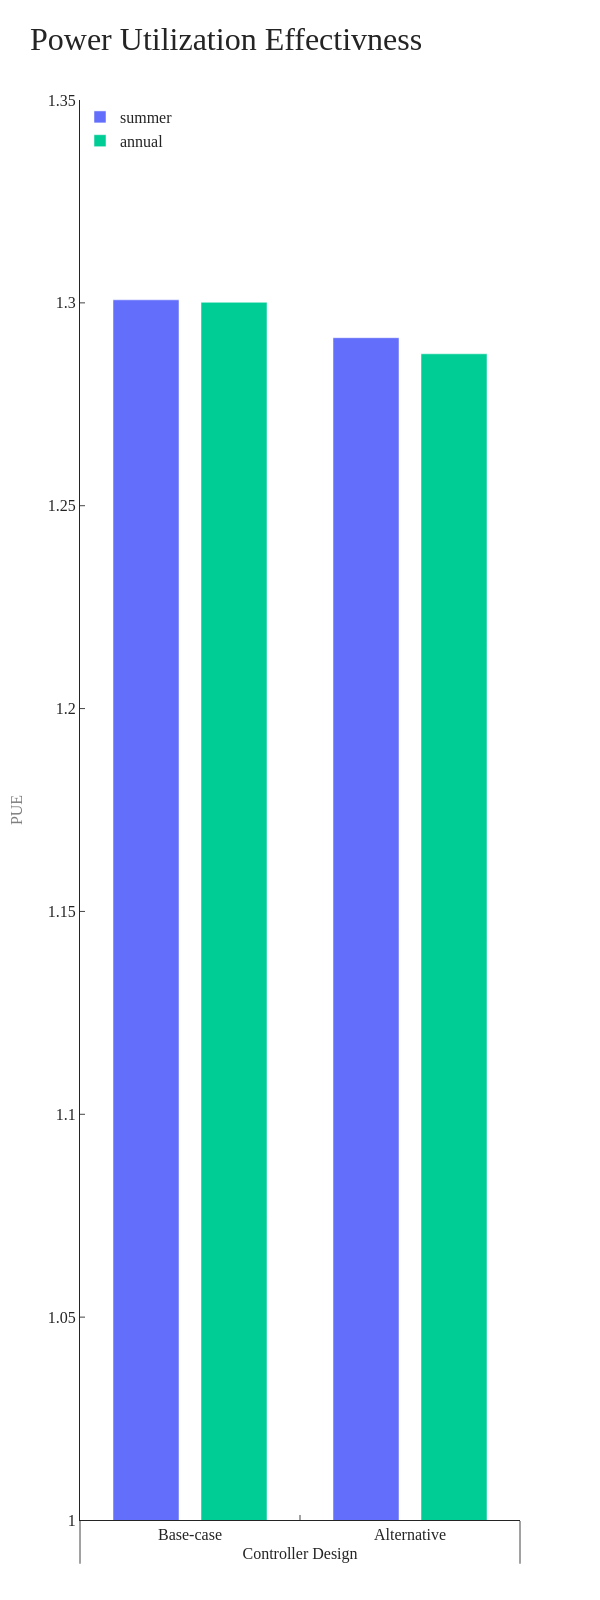

In [35]:
from plotly.offline import iplot, init_notebook_mode

import plotly.graph_objs as go
import plotly.io as pio

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16,
        'color' : "#7f7f7f"}

width = 600
height = 1600

title = "Power Utilization Effectivness"


fig = go.Figure()

fig.update_layout(
    template="simple_white",
#         xaxis=dict(title_text="Simulator, Controller Design"),
#         yaxis=dict(title_text="Energy Use [kWh]"),
    barmode="group",
    font=dict(family=font['family'], size=font['size']),
    title=title,
    titlefont=dict(size=font['size'] * 2.0, family=font['family']),
    xaxis=dict(
        title_text="",
        titlefont=dict(
            family=font['family'],
            size=font['size'],
            color=font['color'],
        ),
        tickfont=dict(size=font['size']),
        ticks="inside"
    ),
    yaxis=dict(
        title_text="PUE",
        range=[1,1.35],
        titlefont=dict(
            family=font['family'],
            size=font['size'],
            color=font['color'],
        ),
        tickfont=dict(size=font['size']),
        ticks="inside"
    ),
    showlegend=True,
    width=width,
    height=height,
#         margin=dict(l=margin_l, b=margin_b),
    legend=dict(
            x=0,
            y=1.,
        font=dict(family=font['family'], size=font['size']),
    ),
)


#     colors = ["#2A66DE", "#FFC32B", "#339933", "#cc9900", "#9933cc"]
colors = ['#636EFA', '#00CC96', '#AB63FA']

# to plot both simulators side by side use 'pue_only' directly 
# in the zip below
pue_single_simulator = pue_only[pue_only["Simulator"] == "dymola"]
pue_single_simulator["Controller Design Label"] = "Controller Design"

for r, c in zip(pue_single_simulator["Season"].unique(), colors):
    plot_df = pue_single_simulator[
        pue_single_simulator["Season"] == r]
#     fig.add_trace(
#         go.Bar(x=[plot_df["Simulator"].apply(
#             lambda x: x.capitalize()), plot_df["Controller Design"].apply(
#               lambda x: x[:-8])], y=plot_df["PUE"], name=r, marker_color=c, width = 0.3),
#     )
    fig.add_trace(
        go.Bar(x=[plot_df["Controller Design Label"], plot_df["Controller Design"]], y=plot_df["PUE"], name=r, marker_color=c, width = 0.3),
    )


img_bytes = fig.to_image(format="png", engine="kaleido")

filename = "pue"

pio.write_image(fig, os.path.join("img", filename + ".png"))

pio.write_image(fig, os.path.join("img", filename + ".pdf"))

from IPython.display import Image
Image(img_bytes)

In [36]:
pue_only

,PUE,Simulator,Controller Design,Season
0,1.30,dymola,Base-case,summer
1,1.29,dymola,Alternative,summer
2,1.30,dymola,Base-case,annual
3,1.29,dymola,Alternative,annual


# Create plots against an independent variable

## Example to access timeseries results for each variable

In [37]:
# Look at some resulting variables
cases.get_list_of_case_names()
# res['optimica']['test_base'].varNames()
(t, P_agg) = res['dymola']['base_summer'].values("QRooIntGaiAgg.y")
P_agg[-1]

4104000000000.0

## Configure plots

In [38]:
plt.rcParams['axes.facecolor']='whitesmoke'
plt.rcParams['font.size'] = 6
plt.rcParams['text.usetex'] = False
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.framealpha'] = 0.75
plt.rcParams['legend.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

def save_plot(figure, file_name):
    """ Save the figure to a pdf and png file in the directory `img`
    """
    import os
    import matplotlib.pyplot as plt
    
    out_dir = "img"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    figure.savefig(os.path.join(out_dir, '{}.pdf'.format(file_name)))
    figure.savefig(os.path.join(out_dir, '{}.png'.format(file_name)))
    plt.clf()
    

def configure_axes(axes):
    """ Configure the axis style
    """
    axes.spines['right'].set_visible(False)
    axes.spines['top'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.grid(color='lightgrey', linewidth=0.25)
    return


# ---------------------------------------------------------------------------
# helper functions and scripts

def set_cases_and_initiate_plot():
    from matplotlib.gridspec import GridSpec
    cases = ['test_base', 'test_alt']
    seasons = ['']
    num_cases = len(cases)
    num_seasons = len(seasons)
    
    fig = plt.figure(figsize=(6.5,8.))
    gs1 = GridSpec(80, 1)
    gs1.update(left=0.1, right=0.9, hspace=0.05)
    
    ax = list()
    ax.insert(0, fig.add_subplot(gs1[0:11,:]))
    ax.insert(1, fig.add_subplot(gs1[12:23,:]))
    ax.insert(2, fig.add_subplot(gs1[28:39,:]))
    ax.insert(3, fig.add_subplot(gs1[40:51,:]))
    ax.insert(4, fig.add_subplot(gs1[56:67,:]))
    ax.insert(5, fig.add_subplot(gs1[68:79,:]))
    
    # fig, ax = plt.subplots(nrows=num_cases*num_seasons, ncols=1, figsize = (6.5,8.))
    # fig, ax = plt.subplots(nrows=20, ncols=1, figsize = (6.5,8.))
    
    return cases, seasons, num_cases, num_seasons, fig, ax

def set_title(ax, title):
    left, width = .01, .97
    bottom, height = .01, .88
    right = left + width
    top = bottom + height
    
    title_str = r"$\it{" + title + "}$"
    ax.text(left, top,
            title_str,
            verticalalignment = 'center',
            horizontalalignment = 'left', 
            transform=ax.transAxes,
            fontsize = 6, color = 'k',
            bbox=dict(facecolor='white', alpha=0.75, edgecolor='none'))
    
    
def set_up_labels(i, ax, cases, seasons, num_cases, num_seasons, x_axis_label, y_axis_label):
    # Hide xtick labels and ticks on the upper case subplot (each basecase)
    if i % 2 == 0:
        hide_tick_labels(ax)

    # Print x axis title only below the lowest subplot
    if i  == num_cases*num_seasons - 1:
        ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))
     
    # Annotate case
    set_title(ax, cases[i % 2])
    # Annotate case
    # if i % 2 == 0:
    #     title_str = r"$\bf{" + seasons[i/2] + "}$" + ' (upper: ' + r"$\it{" + cases[i % 2] + "}$" + ', lower: ' + r"$\it{"  + cases[(i-1) % 2] + "}$" + ')'
    #     ax.set_title(title_str, # mg assign appropriate season/case
    #                  verticalalignment = 'top',
    #                  horizontalalignment = 'center', 
    #                  fontsize = 6, color = 'k')
        
    # Print legend only at the lower plot (g36 case)
    if i % 1 == 0:
        ax.legend(loc='center right', ncol=1)
    configure_axes(ax)
        
    #plt.tight_layout(h_pad=0)
    plt.tight_layout()
    #plt.subplots_adjust(hspace = .2)
        
def tem_conv_CtoF(T_in_degC):
    '''Converts temperature provided in degC to degF
    '''
    T_in_degF = (T_in_degC)*9./5. + 32.
    
    return T_in_degF

def tem_conv_KtoC(T_in_K):
    '''Converts temperature provided in degC to degF
    '''
    T_in_degC = T_in_K - 273.15
    
    return T_in_degC
        
def add_secondary_yaxis_for_degF(ax, time, temp_in_K):
        # Add a secondary axis with temperatures represented in F
        ax_F = ax.twinx()
        # Get limits to match with the left axis
        ax_F.set_ylim([tem_conv_CtoF(ax.get_ylim()[0]),tem_conv_CtoF(ax.get_ylim()[1])])
        # plot a "scaler" variable and make it invisible
        ax_F.plot(time, tem_conv_CtoF(temp_in_K-273.15), linewidth=0.0)
        ax_F.set_ylabel('temperature [$^\circ$F]')
        configure_axes(ax_F)
        #ax.grid(False)
        #ax.xaxis.grid()
        
def hide_tick_labels(ax):
    '''Removes labels and ticks. Kwargs: bottom controls the ticks, labelbottom the tick labels
    '''
    ax.tick_params(axis = 'x',labelbottom='off',bottom='off')

In [39]:
from pdb import set_trace as bp

# for a list of variables, using subplots

def plot_vs_independent_variable(
    res_set,
    var_names, 
    ind_var_name = "weaBus.TWetBul", 
    var_legend_labels = [['$test1$', '$test2$'], ['$test3$']], 
    subplot_x_labels = ["subpl 1", "subpl 2"]):
    ''' Plots a scatter of the variables selected in var_names
    against a provided independent variable, ind_var.
    
    Parameters:
    
        res_set : list or one reader object
            List of reader objects with case results, 
            index represents subplot, or one reader
            for all data
     
        var_names : list of lists
            A list of lists of variable names as provided by the reader, 
            for each subplot
            
        ind_var : str
            Name of the independent variable
            
        var_legend_labels : list of lists
            A list of lists for each subplot
            
        subplot_x_labels : list
            A list of x axis labels for each subplot
    '''
    
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 10}
    
    matplotlib.rc('font', **font)

    n_col = len(var_names)
        
    plt.clf()
    
    if not isinstance(res_set, list):
        res_set = np.repeat(res_set,n_col)
        
    elif not len(res_set) == n_col:
        raise Exception(
            'res_set size mismatch, it should be a list of '\
            'reader objects or a single reader object')
        

    # set the independent variable here, will be taken from the first
    # set or results
    
    ind_var = dict()
    for i in range(n_col):
        (t, ind_var[i]) = res_set[i].values(ind_var_name)
    
        if ".T" in ind_var_name:
            ind_var[i] = tem_conv_KtoC(ind_var[i])
    
    # subplot index
    i = 1
    
    ax = dict()
    
    fig = plt.figure(figsize=(15, 5))
    
    for subplot_var_names in var_names:
        
        v = dict()
        lbl = dict()

        j = 0
        for var in subplot_var_names:

            (t, v[var]) = res_set[i-1].values(var)
            lbl[var] = var_legend_labels[i-1][j]
            
            if ".T" in var:
                v[var] = tem_conv_KtoC(v[var])
                
            j += 1

        # create subplot
        
        ax[i] = fig.add_subplot(1, n_col, i)
        
        for key in v.keys():
            print(lbl[key])
            ax[i].scatter(v[key], ind_var[i-1], label = lbl[key], 
                linewidth=0.5, s = 1.)
            
            ax[i].legend(loc='center right', ncol=1)

        hide_tick_labels(ax[i])

        ax[i].set_xlabel(subplot_x_labels[i - 1])
    
        if i == 1:
            ax[i].set_ylabel('Outdoor air wetbulb temperature [$^\circ$C]')
        
        configure_axes(ax[i])
        
        i += 1
        
        del v
        
    # customize days to display

    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))

#     ax.set_xlim([min(t), min(t)+24])
#     ax.set_xticks(range(24))
 
    
    
    del ind_var
        
    return plt

# Create the plot for all seasons and cases
fig = plot_vs_independent_variable(res["dymola"]["base_annual"], [["pumCHW.dp_in", "TAirSup.T"], ["pumCHW.m_flow"]], 
                                   var_legend_labels = [["CHW pump dif. pressure", "Air supply temperature"], ["CHW pump flow"]])
save_plot(fig, "test_many")


fig = plot_vs_independent_variable(res["dymola"]["alt_annual"], [["TChiWatSupSen.T"], ["TConWatRetSen.T"]], 
                                   var_legend_labels = [["CHW loop temperature [$^\circ$C]"],["CW loop temperature [$^\circ$C]"]])
save_plot(fig, "CWreset_loop_temps")

fig = plot_vs_independent_variable([res["dymola"]["base_annual"],res["dymola"]["alt_annual"]], 
                                   [["waterSideEconomizerOnOff.yOn"], ["yWSEOn.y"]], 
                                   subplot_x_labels = ["base_annual", "alt_annual"],
                                   var_legend_labels = [["WSE on/off signal"],["WSE on/off signal"]])
save_plot(fig, "WSE_on_vs_outdoor_wetbulb")

CHW pump dif. pressure
Air supply temperature
CHW pump flow
CHW loop temperature [$^\circ$C]
CW loop temperature [$^\circ$C]
WSE on/off signal
WSE on/off signal


In [40]:
from pdb import set_trace as bp

# works for one variable

def plot_vs_independent_variable(
    res_set,
    x_var_name, 
    ind_var_name = "weaBus.TWetBul",
    var_legend_label = 'legend label',
    x_label = "x label",
    y_label = "Outdoor air wetbulb temperature [$^\circ$C]"):
    
    ''' Plots a scatter of x_var_name
    against a provided ind_var_name.
    '''
    
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 6}
    
    matplotlib.rc('font', **font)
    
    plt.clf()

    # set an independent variable here
    (t, y_var) = res_set.values(ind_var_name)
    (t, x_var) = res_set.values(x_var_name)
    
    if ".T" in ind_var_name:
        y_var = tem_conv_KtoC(y_var)
        
    if ".T" in x_var_name:
        x_var = tem_conv_KtoC(x_var)

    # create subplot

    fig = plt.figure(figsize=(4.5, 4.5))
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(x_var, y_var, label = var_legend_label, 
        linewidth=0.5, s = 1.)

    hide_tick_labels(ax)

    ax.set_xlabel(x_label)

    ax.set_ylabel(y_label)
        
    # customize days to display

    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))

#     ax.set_xlim([min(t), min(t)+24])
#     ax.set_xticks(range(24))
 
    ax.legend(loc='center right', ncol=1)

    configure_axes(ax)
    
    del y_var, x_var
        
    return plt

# Create the plot for all seasons and cases
fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "pumCHW.dp_in", "weaBus.TWetBul", x_label = "CHW loop differential pressure [Pa]")
# fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "chilledWaterReset.uChiWatPlaRes", "chilledWaterReset.TChiWatSupSet")
save_plot(fig, "test_one_var_vs_indep")

fig = plot_vs_independent_variable(res["dymola"]["alt_annual"], "TChiWatSupSen.T", "weaBus.TWetBul", x_label = "CHW loop temperature [$^\circ$C]")
# fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "chilledWaterReset.uChiWatPlaRes", "chilledWaterReset.TChiWatSupSet")
save_plot(fig, "chw_temp_vs_wetbulb")

fig = plot_vs_independent_variable(res["dymola"]["alt_annual"], "TConWatRetSen.T", "weaBus.TWetBul", x_label = "CW loop temperature [$^\circ$C]")
# fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "chilledWaterReset.uChiWatPlaRes", "chilledWaterReset.TChiWatSupSet")
save_plot(fig, "cw_temp_vs_wetbulb")

fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "chilledWaterReset.uChiWatPlaRes", "weaBus.TWetBul", x_label = "CHW reset control signal [1]")
# fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "chilledWaterReset.uChiWatPlaRes", "chilledWaterReset.TChiWatSupSet")
save_plot(fig, "chw_reset_u_vs_wetbulb_base")

fig = plot_vs_independent_variable(res["dymola"]["alt_annual"], "cooTow.y", "weaBus.TWetBul", x_label = "Tower fan speed [-]")
# fig = plot_vs_independent_variable(res["dymola"]["base_annual"], "chilledWaterReset.uChiWatPlaRes", "chilledWaterReset.TChiWatSupSet")
save_plot(fig, "tower_fan_speed_vs_wetbulb")

In [41]:
# var_legend_labels = [['$test1$', '$test2$'], '$test3$']
# var_legend_labels[1,1]

# Control diagrams through simulation

In [ ]:
def plot_control_diagram(
    res_set,
    y_var_name,
    sec_y_var_name,
    x_var_name = "weaBus.TWetBul",
    x_legend_label = 'x legend label',
    y_legend_label = 'y legend label',
    x_label = "x label",
    y_label = "y label",
    sec_y_label = "sec y label",
    ):
    
    ''' 
    '''
    
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 6}
    
    matplotlib.rc('font', **font)
    
    plt.clf()

    # set variables
    (t, x_var) = res_set.values(x_var_name)
    (t, y_var) = res_set.values(y_var_name)
    (t, sec_y_var) = res_set.values(sec_y_var_name)
    print(sec_y_var.mean())
    
    if ".T" in y_var_name:
        y_var = tem_conv_KtoC(y_var)
    
    if ".T" in sec_y_var_name:
        sec_y_var = tem_conv_KtoC(sec_y_var)
    print(sec_y_var.mean())
    print(x_var.mean())
    # create subplot

    fig = plt.figure(figsize=(4.5, 4.5))
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(x_var, y_var, label = x_legend_label, 
        linewidth=0.5, s = 1.)
    
    ax_2 = ax.twinx()
    # plot a "scaler" variable and make it invisible
    ax_2.scatter(x_var, sec_y_var,  
              label = y_legend_label, linewidth=0.5, s = 1., color = "green")

    hide_tick_labels(ax)
    hide_tick_labels(ax_2)
    
    configure_axes(ax)
    configure_axes(ax_2)
    
    ax_2.set_ylabel(sec_y_label)

    ax.set_xlabel(x_label)

    ax.set_ylabel(y_label)
        
    # customize days to display

    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))

#     ax.set_xlim([min(t), min(t)+24])
#     ax.set_xticks(range(24))
 
#     ax.legend(loc='center right', ncol=1)
    ax_2.legend(['Right axis'], loc='center right', ncol=1)
    
    del y_var, sec_y_var
        
    return plt


fig = plot_control_diagram(res["dymola"]["base_annual"], 
    "chilledWaterReset.dpChiWatPumSet", "chilledWaterReset.TChiWatSupSet", x_var_name = "chilledWaterReset.uChiWatPlaRes",
    x_label = "CHW reset control signal",
    y_label = "CHW pump differential pressure setpoint [Pa]",
    sec_y_label = "CHW supply temperature setpoint [$^\circ$C]")

save_plot(fig, "base_annual_chw_reset_control_diagram")

fig = plot_control_diagram(res["dymola"]["alt_annual"], 
    "chilledWaterReset.dpChiWatPumSet", "chilledWaterReset.TChiWatSupSet", x_var_name = "chilledWaterReset.uChiWatPlaRes",
    x_label = "CHW reset control signal",
    y_label = "CHW pump differential pressure setpoint [Pa]",
    sec_y_label = "CHW loop temperature [$^\circ$C]")

save_plot(fig, "alt_heapreval_wse_annual_chw_reset_control_diagram")

fig = plot_control_diagram(res["dymola"]["alt_annual"], 
    "heaPreCon.yMaxTowSpeSet", "heaPreCon.yConWatPumSpeSet", x_var_name = "heaPreCon.chiHeaPreLoo.yHeaPreCon",
    x_label = "CW reset control signal",
    y_label = "Cooling tower fan speed",
    sec_y_label = "CW pump speed")

# save_plot(fig, "alt_heapreval_wse_annual_control_diagram")
save_plot(fig, "alt_head_pressure_control_diagram")


fig = plot_control_diagram(res["dymola"]["base_annual"], 
    "chi.TEvaLvg", "chi.TConLvg", x_var_name = "chi.EIRFunT",
    x_label = "Chiller energy input ratio quadratic curve",
    y_label = "CHW Supply Temperature (Evaporator Leaving Water)",
    sec_y_label = "CW Return Temperature (Condenser Leaving Water)")

# save_plot(fig, "alt_heapreval_wse_annual_control_diagram")
save_plot(fig, "base_annual_EIRFunT_vs_evaLea_and_conEnt")

fig = plot_control_diagram(res["dymola"]["alt_annual"],
    "towCon.towFanSpe.fanSpeWse.intOpe.loaCon.y", "towCon.towFanSpe.fanSpeWse.wseOpe.chiWatTemCon.y", x_var_name = "cooTow.y",
    x_label = "Tower fan speed",
    y_label = "Minimum chiller capacity control signal (Integrated)",
    sec_y_label = "Chilled water supply temperature control loop (WSE Only)")

save_plot(fig, "alt_tower_fan_control")

fig = plot_control_diagram(res["dymola"]["alt_annual"], 
    "towCon.TChiWatSup", "chilledWaterReset.TChiWatSupSet", x_var_name = "cooTow.y",
    x_label = "Tower fan speed",
    y_label = "CHW supply temperature [$^\circ$C]",
    sec_y_label = "CHW supply temperature setpoint [$^\circ$C]")

save_plot(fig, "alt_tower_fan_control_1")

fig = plot_control_diagram(res["dymola"]["alt_annual"], 
    "cooTow.y", "pumCHW.dp", x_var_name = "weaBus.TWetBul",
    x_label = "Outdoor wetbulb temperature [$^\circ$C]",
    y_label = "Tower fan speed",
    sec_y_label = "CHW dp")

save_plot(fig, "alt_tower_fan_control_2")

295.14157
21.991625
0.027368069
295.1498
21.999886
0.10674022
0.50140315
0.50140315
0.99962646
296.14575
22.99578
0.00034150897
0.23990579
0.23990579
0.39085495


# Statistical density plots

In [ ]:
# compare base and alternative controller WSE only and integrated mode 
# as box plots vs. outdoor wetbulb temperature

base = data["dymola"]["base_annual"].copy()
alt = data["dymola"]["alt_annual"].copy()

base_int = base[base["chi.on"] == 1.]
base_int = base_int[base_int["waterSideEconomizerOnOff.yOn"] == 1.]
base_int["Design"] = "Base"
base_int["Operating Mode"] = "Integrated"
base_wse = base[base["chi.on"] == 0.]
base_wse = base_wse[base_wse["waterSideEconomizerOnOff.yOn"] == 1.]
base_wse["Design"] = "Base"
base_wse["Operating Mode"] = "WSE-only"

base_int["Wet Bulb Temperature, [$^\circ$C]"] = tem_conv_KtoC(base_int["weaBus.TWetBul"])
base_int1 = base_int.loc[:, ["Operating Mode", "Design", "Wet Bulb Temperature, [$^\circ$C]"]]
base_wse["Wet Bulb Temperature, [$^\circ$C]"] = tem_conv_KtoC(base_wse["weaBus.TWetBul"])
base_wse1 = base_wse.loc[:, ["Operating Mode", "Design", "Wet Bulb Temperature, [$^\circ$C]"]]

alt_int = alt[alt["chi.on"] == 1.]
alt_int = alt_int[alt_int["yWSEOn.y"] == 1.]
alt_int["Design"] = "Alternative"
alt_int["Operating Mode"] = "Integrated"
alt_wse = alt[alt["chi.on"] == 0.]
alt_wse = alt_wse[alt_wse["yWSEOn.y"] == 1.]
alt_wse["Design"] = "Alternative"
alt_wse["Operating Mode"] = "WSE-only"

alt_int["Wet Bulb Temperature, [$^\circ$C]"] = tem_conv_KtoC(alt_int["weaBus.TWetBul"])
alt_int1 = alt_int.loc[:, ["Operating Mode", "Design", "Wet Bulb Temperature, [$^\circ$C]"]]
alt_wse["Wet Bulb Temperature, [$^\circ$C]"] = tem_conv_KtoC(alt_wse["weaBus.TWetBul"])
alt_wse1 = alt_wse.loc[:, ["Operating Mode", "Design", "Wet Bulb Temperature, [$^\circ$C]"]]

plot_df = pd.concat((base_int1, alt_int1,base_wse1, alt_wse1))

plot_df["Operating Mode"].unique()

# Check
print(base[base["chi.on"] == 1.].shape[0]/base.shape[0])
print(alt[alt["chi.on"] == 1.].shape[0]/alt.shape[0])

plot_df.groupby(["Design", "Operating Mode"]).count()/base.shape[0]


In [ ]:
import plotly.express as px

fig = px.box(plot_df, y="Wet Bulb Temperature, [$^\circ$C]", x="Operating Mode", color="Design", 
          hover_data=plot_df.columns)

    
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20,
        'color' : "#7f7f7f"}

fig.update_layout(
    boxgap = 0.3,
    boxgroupgap = 0.5,
    template="simple_white",
#         xaxis=dict(title_text="Season, Controller Design"),
#         yaxis=dict(title_text="Energy Use [kWh]"),
    font=dict(family=font['family'], size=font['size']),
#     title="Operating Mode Configuration",
    titlefont=dict(size=font['size'] * 2.0, family=font['family']),
    xaxis=dict(
        titlefont=dict(
            family=font['family'],
            size=font['size'] * 1.2,
            color=font['color'],
        ),
        tickfont=dict(size=font['size']),
    ),
    yaxis=dict(
        title_text="Wet Bulb Temperature [℃]",
        titlefont=dict(
            family=font['family'],
            size=font['size'] * 1.2,
            color=font['color'],
        ),
        tickfont=dict(size=font['size']),
    ),
    showlegend=True,
    width=400,
    height=800,
#         margin=dict(l=margin_l, b=margin_b),
    legend=dict(
        x=0.05,
        y=0.1,
        bgcolor = 'rgba(255,255,255,0.6)',
        font=dict(family=font['family'], size=font['size']*.8),
    ),
)

fig.show()

img_bytes = fig.to_image(format="png", engine="kaleido")

filename = "operating_modes_vs_wetbulb_boxplots"

pio.write_image(fig, os.path.join("img", filename + ".png"))

pio.write_image(fig, os.path.join("img", filename + ".pdf"))

In [ ]:
# For those temperatures in the range 10 -15 degC, where both integrated and WSE only Operating Mode configurations exist
# describe the data

int_overlap = alt_int[(alt_int["Wet Bulb Temperature, [$^\circ$C]"] > 10)]
int_overlap = int_overlap[(int_overlap["Wet Bulb Temperature, [$^\circ$C]"] < 15)]

wse_overlap = alt_wse[(alt_wse["Wet Bulb Temperature, [$^\circ$C]"] > 10)]
wse_overlap = wse_overlap[(wse_overlap["Wet Bulb Temperature, [$^\circ$C]"] < 15)]

print("Integrated: \n\n", int_overlap.describe().round(2))

In [ ]:
print("WSE: \n\n", wse_overlap.describe().round(2))

In [ ]:
wse_overlap.head()

## Chiller performance checks

In [ ]:
# aggregate data timeseries
chi_dat = dict()
chi_dat = {"dymola": dict()}
simulators = ["dymola"]
for simulator in simulators:
    for case in ["base_annual"]:
        chi_dat[simulator][case] = get_partial_results(
            case,  ["chi.EIRFunT", "chi.capFunT","chi.TEvaLvg", "chi.TConLvg", "chi.on", "chi.P","chi.PLR1","chi.PLR2"], 
            simulator, as_dataframe=True, equidistant = simulator == "dymola")
        chi_dat[simulator][case] = chi_dat[simulator][case].loc[(chi_dat[simulator][case].index % 2)==0,:].reset_index(drop=True)
chi = chi_dat["dymola"]["base_annual"]

chi.head()

chi = chi[chi.columns.drop(list(chi.filter(regex='time_')))]

chi_base_on = chi[chi["chi.on"] == 1.]
print("base:\n\n", chi_base_on.describe())

In [ ]:
chi_alt_dat = dict()
chi_alt_dat = {"dymola": dict()}
simulators = ["dymola"]
for simulator in simulators:
    for case in ["alt_annual"]:
        chi_dat[simulator][case] = get_partial_results(
            case,  ["chi.EIRFunT", "chi.capFunT","chi.TEvaLvg", "chi.TConLvg", "chi.on", "chi.P","chi.PLR1","chi.PLR2"], 
            simulator, as_dataframe=True, equidistant = simulator == "dymola")
        chi_dat[simulator][case] = chi_dat[simulator][case].loc[(chi_dat[simulator][case].index % 2)==0,:].reset_index(drop=True)
chi_alt = chi_dat["dymola"]["alt_annual"]

chi_alt.head()

chi_alt = chi_alt[chi_alt.columns.drop(list(chi_alt.filter(regex='time_')))]

chi_alt_on = chi_alt[chi_alt["chi.on"] == 1.]

In [ ]:
print("alt:\n\n", chi_alt_on.describe())

In [ ]:
# 

check_p = chi_base_on[chi_base_on["chi.TEvaLvg"] >= chi_base_on["chi.TConLvg"]]
check_p["lift"] = -check_p["chi.TEvaLvg"].subtract(chi_on["chi.TConLvg"])
check_p.sort_values("lift", ascending = False)

chi_base_on

In [ ]:
check_p = chi_alt_on[chi_alt_on["chi.TEvaLvg"] <= chi_alt_on["chi.TConLvg"]]
check_p["lift"] = -check_p["chi.TEvaLvg"].subtract(chi_on["chi.TConLvg"])
check_p.sort_values("lift", ascending = False)

check_p.describe()
check_p

In [ ]:
# 3d plot to check chiller performance outside of the usual range (at low lift region)

# res["dymola"]["alt_heapreval_annual"].varNames()
#  (t, sec_y_var) = res["dymola"]["alt_heapreval_annual"].values("chilledWaterReset.TChiWatSupSet")
# (t, x_var) = res["dymola"]["base_annual"].values("chi.EIRFunT")
# (t, y_var) = res["dymola"]["base_annual"].values("chi.TEvaLvg")
# (t, sec_y_var) = res["dymola"]["base_annual"].values("chi.TConEnt")
# plt.contour([y_var, sec_y_var], x_var, [10, 30, 50])

y_var = chi_on["chi.TEvaLvg"].values
sec_y_var = chi_on["chi.TConLvg"].values
x_var = chi_on["chi.EIRFunT"].values

from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')

sec_y_var = tem_conv_KtoC(sec_y_var)
y_var = tem_conv_KtoC(y_var)

fig = ax.scatter3D(y_var, sec_y_var, x_var, c=x_var,cmap='viridis', marker = '.', linewidth=0.5) 

ax.set_xlabel('CHW Supply Temperature (Evaporator Leaving Water)')
ax.set_ylabel('CW Return Temperature (Condenser Leaving Water)')
ax.set_zlabel('Chiller energy input ratio quadratic curve')

save_plot(plt, "Base - Chiller energy input ratio quadratic curve_3d")


y_var = chi_on["chi.TEvaLvg"].values
sec_y_var = chi_alt_on["chi.TConLvg"].values
x_var = chi_alt_on["chi.EIRFunT"].values

ax = plt.axes(projection='3d')

sec_y_var = tem_conv_KtoC(sec_y_var)
y_var = tem_conv_KtoC(y_var)

fig = ax.scatter3D(y_var, sec_y_var, x_var, c=x_var,cmap='viridis', marker = '.', linewidth=0.5) 

ax.set_xlabel('CHW Supply Temperature (Evaporator Leaving Water)')
ax.set_ylabel('CW Return Temperature (Condenser Leaving Water)')
ax.set_zlabel('Chiller energy input ratio quadratic curve')

save_plot(plt, "alt - Chiller energy input ratio quadratic curve_3d")

# check capFunT

y_var = chi_alt_on["chi.TEvaLvg"].values
sec_y_var = chi_alt_on["chi.TConLvg"].values
x_var = chi_alt_on["chi.capFunT"].values

ax = plt.axes(projection='3d')

sec_y_var = tem_conv_KtoC(sec_y_var)
y_var = tem_conv_KtoC(y_var)

fig = ax.scatter3D(y_var, sec_y_var, x_var, c=x_var,cmap='viridis', marker = '.', linewidth=0.5) 

ax.set_xlabel('CHW Supply Temperature (Evaporator Leaving Water)')
ax.set_ylabel('CW Return Temperature (Condenser Leaving Water)')
ax.set_zlabel('Cooling capacity factor function of temperature curve')

save_plot(plt, "alt - Cooling capacity factor function of temperature curve_3d")

y_var = chi_on["chi.TEvaLvg"].values
sec_y_var = chi_on["chi.TConLvg"].values
x_var = chi_on["chi.capFunT"].values

ax = plt.axes(projection='3d')

sec_y_var = tem_conv_KtoC(sec_y_var)
y_var = tem_conv_KtoC(y_var)

fig = ax.scatter3D(y_var, sec_y_var, x_var, c=x_var,cmap='viridis', marker = '.', linewidth=0.5) 

ax.set_xlabel('CHW Supply Temperature (Evaporator Leaving Water)')
ax.set_ylabel('CW Return Temperature (Condenser Leaving Water)')
ax.set_zlabel('Cooling capacity factor function of temperature curve')

save_plot(plt, "Base - Cooling capacity factor function of temperature curve_3d")

# Timeseries plots

## Chiller plant - power

*mg adjust this method to take various cases as needed

In [ ]:
def plot_power(res_set):
    ''' Main method that plots the results
    '''
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 6}
    matplotlib.rc('font', **font)
    
    plt.clf()
    
    time_scale=3600.
       
    (t, pumCHW_P) = res_set.values("pumCHW.P")
    (t, pumCW_P) = res_set.values("pumCW.P")
    (t, chi_P) = res_set.values("chi.P")
    t = t/time_scale
   
    # Plot figure
    fig = plt.figure(figsize=(6.5, 2.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(t, pumCHW_P, label = '$P_{chw,p}$', linewidth=0.5)
         
    # make_ticklabels_invisible(plt.gcf())
        
    # customize days to display

    ax.set_xlabel('time [h]')
    ax.set_ylabel('Chiller water pump power [W]')
    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))

    ax.set_xlim([min(t), min(t)+24])
    ax.set_xticks(range(24))
 
    ax.legend(loc='center right', ncol=1)

    configure_axes(ax)
        
    return plt

# Create the plot for all seasons and cases
fig = plot_power(res["dymola"]["base_annual"])
save_plot(fig, "CHWpum_P")

In [ ]:
def plot_tower_fan_speed(res_set):
    ''' Main method that plots the results
    '''
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 6}
    matplotlib.rc('font', **font)
    
    plt.clf()
    
    time_scale=3600.
       
    (t, twy) = res_set.values("cooTow.y")
    t = t/time_scale
   
    # Plot figure
    fig = plt.figure(figsize=(6.5, 2.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(t, twy, label = '$-$', linewidth=0.5)
         
    # make_ticklabels_invisible(plt.gcf())
        
    # customize days to display

    ax.set_xlabel('time [h]')
    ax.set_ylabel('Tower fan control signal')
    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))

    ax.set_xlim([min(t), max(t)])
#     ax.set_xticks(range(24))
 
    ax.legend(loc='center right', ncol=1)

    configure_axes(ax)
        
    return plt

# Create the plot for all seasons and cases
fig = plot_tower_fan_speed(res["dymola"]["alt_annual"])
save_plot(fig, "Tow_fan_speed_timeseries")

In [ ]:
def plot_wet_bulb(res_set):
    ''' Main method that plots the results
    '''
    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 6}
    matplotlib.rc('font', **font)
    
    plt.clf()
    
    time_scale=3600.
       
    (t, twy) = res_set.values("weaBus.TWetBul")
    t = t/time_scale
   
    # Plot figure
    fig = plt.figure(figsize=(6.5, 2.5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(t, twy, label = '$-$', linewidth=0.5)
         
    # make_ticklabels_invisible(plt.gcf())
        
    # customize days to display

    ax.set_xlabel('time [h]')
    ax.set_ylabel('Tower fan control signal')
    #ax.xaxis.set_ticks(np.arange(min(t)+0, 365, 1))

    ax.set_xlim([min(t), max(t)])
#     ax.set_xticks(range(24))
 
    ax.legend(loc='center right', ncol=1)

    configure_axes(ax)
        
    return plt

# Create the plot for all seasons and cases
fig = plot_tower_fan_speed(res["dymola"]["alt_annual"])
save_plot(fig, "wet_bulb_timeseries_alt")

## Outside conditions

In [ ]:
def plot_outside(res_set):
    # ------------------------------------------------------
    plt.clf()
    plt.ylim([0., 20.])
    time_scale=86400.
    # ------------------------------------------------------
    
    ax = list()
    # get a list of unique climate cases
    unique_climate_cases = list(res_set.keys())[0] # all in the same climate
    
    subplot_id = 0
    for climate in unique_climate_cases:
        (t, TOut) = res_set[case_name].values("weaBus.TDryBul")
        (t, TOutWet) = res_set[case_name].values("weaBus.TWetBul")
        
        t = t/time_scale
        
        # Generate figure and plot data
        ax.insert(subplot_id, plt.subplot(len(unique_climate_cases)*2, 1, subplot_id+1))
        
        for subplot_id in [0,2,4]:
            ax[subplot_id].plot(t, TOut-273.15, 'r', \
                   label='$T_{oa}$', linewidth=0.5)
            ax[subplot_id].set_ylabel('temperature [$^\circ$C]')
            add_secondary_yaxis_for_degF(ax[subplot_id], t, TOut)
            set_title(ax[subplot_id], '$T_{oa}$')
        
        subplot_id += 1
        
        for subplot_id in [1,3,5]:
            ax[subplot_id].plot(t, TOutWet-273.15, 'r', \
                   label='$T_{oa,w}$', linewidth=0.5)
            ax[subplot_id].set_ylabel('temperature [$^\circ$C]')
            add_secondary_yaxis_for_degF(ax[subplot_id], t, TOutWet)
            set_title(ax[subplot_id], '$T_{oa,w}$')
        
        # customize days to display
        ax[subplot_id].set_xlim([min(t)+5, min(t)+10])

        configure_axes(ax[subplot_id])
        ax[subplot_id].legend(loc='center right', ncol=1)
        
        subplot_id += 1

#     ax[5].set_xlabel('time [days]')

    return plt

# Create the plot for all seasons and cases
fig = plot_outside(res["dymola"])
save_plot(fig, "outside")

cases.get_list_of_case_names()
